In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
import torch.nn.functional as F
from torch.optim import Adam
from tqdm.auto import trange
import torch.nn as nn
from glob import glob
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from dgl.dataloading import GraphDataLoader

from cloudmanufacturing.data import read_fatahi_dataset
from cloudmanufacturing.graph import dglgraph, graph_gamma, os_type, so_type, ss_type
from cloudmanufacturing.graphconv import GNN
from cloudmanufacturing.solvers.mip_solver import mip_solve
from cloudmanufacturing.validation import construct_delta, objvalue, construct_delta2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
dataset = read_fatahi_dataset("../data/fatahi.xlsx")

  0%|          | 0/18 [00:00<?, ?it/s]

In [3]:
def dglgraph_fixed(graph, oper_max=20):
        ncolumns = graph.ndata['feat']['o'].shape[1]
        graph.ndata['feat'] = {'o': F.pad(graph.ndata['feat']['o'], [0, oper_max - ncolumns])}
        return graph

In [4]:
class GraphDataset(Dataset):
    def __init__(self, problems, gammas, deltas):
        self.problems = problems
        self.gammas = gammas
        self.deltas = deltas

    def __len__(self):
        return len(self.problems)

    def __getitem__(self, idx):
        problem = self.problems[idx]
        gamma = self.gammas[idx]
        delta = self.deltas[idx]

        graph = dglgraph(problem, gamma, delta)
        graph = dglgraph_fixed(graph)
        graph.edata["feat"][os_type][:, 0] /= 10
        graph.edata["feat"][ss_type] /= 100
        return graph

In [5]:
def parse_idx(string):
    number = re.search(r'\d+', string).group()
    return int(number)

solved_indexes = np.unique([parse_idx(l) for l in glob('solutions/*')])

In [6]:
info = {}
for idx in solved_indexes:
    if f'solutions/gamma_{idx}.npy' in glob('solutions/*'):
        info[idx] = {}
        info[idx]['gamma'] = np.load(f'solutions/gamma_{idx}.npy')
        info[idx]['delta'] = np.load(f'solutions/delta_{idx}.npy')

In [7]:
train_idx, test_idx = train_test_split(solved_indexes,
                                       random_state=42)

In [8]:
train_dataset = GraphDataset([dataset[i] for i in train_idx],
                             [info[i]['gamma'] for i in train_idx],
                             [info[i]['delta'] for i in train_idx])

test_dataset = GraphDataset([dataset[i] for i in test_idx],
                            [info[i]['gamma'] for i in test_idx],
                            [info[i]['delta'] for i in test_idx])

In [9]:
train_loader = GraphDataLoader(train_dataset, batch_size=3, shuffle=True)
test_loader = GraphDataLoader(test_dataset, batch_size=3, shuffle=True)

In [10]:
def validate_objective(model, indexes, problems, dataset):
    test_objvalue = []
    for i, idx in enumerate(indexes):
        pred_gamma, pred_delta = model.predict(dataset.__getitem__(i), problems[idx])
        test_objvalue.append(
            objvalue(problems[idx], pred_gamma, pred_delta)
        )
    return np.mean(test_objvalue)

In [11]:
model = GNN(s_shape=1, o_shape=20, os_shape=2,
            ss_shape=10, out_dim=15, n_layers=1)

loss2 = nn.CrossEntropyLoss()

train_loss = []
test_loss = []
train_objvalue = []
test_objvalue = []

optim = Adam(model.parameters(), lr=0.005)
for epoch in trange(50):
    train_loss_ep = []
    test_loss_ep = []
    train_objvalue_ep = []
    test_objvalue_ep = []
    for graph in train_loader:
        gamma_target = graph.edata["target"][os_type]
        delta_target = graph.edata["delta_target"][ss_type]
        mask = graph.edata["mask"][ss_type]
        logits, delta_logits = model(graph)
        loss = F.binary_cross_entropy_with_logits(logits, gamma_target)
        serv = loss2(delta_logits[mask], delta_target[mask])
        loss = loss + serv
        optim.zero_grad()
        loss.backward()
        optim.step()
        train_loss_ep.append(loss.item())
        train_objvalue_ep.append(validate_objective(model,train_idx,dataset,train_dataset))

    for graph in test_dataset:
        with torch.no_grad():
            gamma_target = graph.edata["target"][os_type]
            delta_target = graph.edata["delta_target"][ss_type]
            mask = graph.edata["mask"][ss_type]
            logits, delta_logits = model(graph)
            loss = F.binary_cross_entropy_with_logits(logits, gamma_target)
            serv = loss2(delta_logits[mask], delta_target[mask])
            loss = loss + serv
            test_loss_ep.append(loss.item())
            test_objvalue_ep.append(validate_objective(model,test_idx, dataset, test_dataset))

    train_loss.append(np.mean(train_loss_ep))
    test_loss.append(np.mean(test_loss_ep))
    train_objvalue.append(np.mean(train_objvalue_ep))
    test_objvalue.append(np.mean(test_objvalue_ep))

  0%|          | 0/50 [00:00<?, ?it/s]

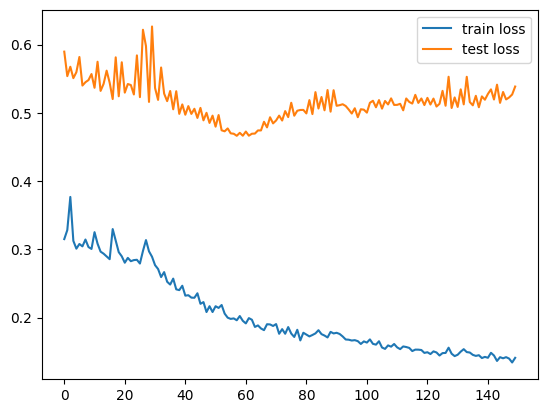

In [ ]:
plt.plot(train_loss, label="train loss")
plt.plot(test_loss, label="test loss")
plt.legend()
plt.show()

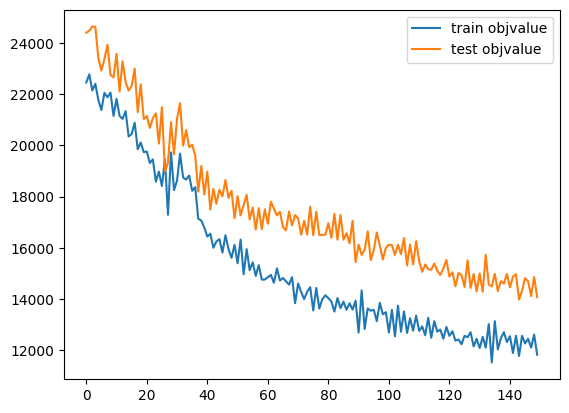

In [ ]:
plt.plot(train_objvalue, label="train objvalue")
plt.plot(test_objvalue, label="test objvalue")
plt.legend()
plt.show()

In [ ]:
min(test_objvalue)

13981.708645715553

In [ ]:
min(train_objvalue)

11524.576735760958